In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import pandas as pd
import numpy as np
import random

In [2]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)  

In [3]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,X,Y,Z,A0,A1,A2,A5,A6,A7
0,0.000000,-0.759297,0.419074,3.31,2.01,0.0,1.94,1.58,1.65
1,0.058824,-0.759205,0.418863,3.39,2.23,0.0,2.09,1.73,1.80
2,0.117647,-0.759242,0.419042,3.46,2.16,0.0,2.09,1.80,1.87
3,0.176471,-0.759302,0.419248,3.67,2.30,0.0,2.23,1.87,1.94
4,0.235294,-0.759177,0.418970,3.82,2.30,0.0,2.16,1.87,1.94


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10708 entries, 0 to 10707
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       10708 non-null  float64
 1   Y       10708 non-null  float64
 2   Z       10708 non-null  float64
 3   A0      10708 non-null  float64
 4   A1      10708 non-null  float64
 5   A2      10708 non-null  float64
 6   A5      10708 non-null  float64
 7   A6      10708 non-null  float64
 8   A7      10708 non-null  float64
dtypes: float64(9)
memory usage: 753.0 KB


In [5]:
X, y = dataset[["X", "Y", "Z"]], dataset[['A0', 'A1', 'A2', 'A5', 'A6', 'A7']]

x_mean = X.iloc[:, 0].mean()

x_std = X.iloc[:, 0].std()
y_mean = X.iloc[:, 1].mean()
y_std = X.iloc[:, 1].std()
z_mean = X.iloc[:, 2].mean()
z_std = X.iloc[:, 2].std()

# Normalize each column
X_norm = np.copy(X)
X_norm[:, 0] = (X.iloc[:, 0] - x_mean) / x_std
X_norm[:, 1] = (X.iloc[:, 1] - y_mean) / y_std
X_norm[:, 2] = (X.iloc[:, 2] - z_mean) / z_std

y_norm = y / 73.8

In [6]:
X_norm = torch.tensor(pd.DataFrame(X_norm).values, dtype=torch.float32)
y_norm = torch.tensor(pd.DataFrame(y_norm).values, dtype=torch.float32)

X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
X_train

tensor([[-0.9425,  0.6090,  1.6928],
        [-0.7765,  1.6047,  0.8203],
        [ 1.5648, -0.5537,  0.8535],
        ...,
        [-0.1568, -0.2147, -1.0535],
        [-1.2321, -1.6867,  0.6647],
        [ 0.6153,  0.3961,  0.7643]])

In [8]:
# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
class LinearlyActuatedStrutsXavier(nn.Module):
    def __init__(self):
        super(LinearlyActuatedStrutsXavier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6),
            nn.Sigmoid()  # Constrain to [0, 1]
        )
        
        # Initialize weights with Xavier/Glorot initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                torch.manual_seed(42) # Set seed for reproducibility
                init.xavier_uniform_(m.weight)  # Xavier uniform initialization
                if m.bias is not None:
                    nn.init.zeros_(m.bias)      # Initialize biases to zero

    def forward(self, x):
        return self.model(x)
    

class LinearlyActuatedStrutsHe(nn.Module):
    def __init__(self):
        super(LinearlyActuatedStrutsHe, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6),
            nn.Sigmoid()  # Constrain to [0, 1]
        )
        
        # Initialize weights with Xavier/Glorot initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                torch.manual_seed(42) # Set seed for reproducibility
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)


In [19]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    model_name: str = "model",
    criterion: nn.Module = nn.MSELoss(),
    optimizer: torch.optim.Optimizer = None,
    lr: float = 1e-3,
    num_epochs: int = 100,
    scale_factor: float = 73.8,  
    save_best: bool = True,
    verbose: bool = True
) -> dict:
    """
    Train and evaluate a single PyTorch model
    
    Args:
        model: Initialized PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        model_name: Name for saving/printing
        criterion: Loss function (default MSELoss)
        optimizer: Optimizer (defaults to Adam if None)
        lr: Learning rate if optimizer is None
        num_epochs: Training epochs
        scale_factor: Loss scaling factor
        save_best: Whether to save best model weights
        verbose: Print progress
    
    Returns:
        Dictionary with training history and best model state
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'best_val_loss': float('inf'),
        'best_model_state': None,
        'epoch_best': 0
    }
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # Validation
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        # Record metrics
        train_loss = train_loss / len(train_loader.dataset) * scale_factor
        val_loss = val_loss / len(val_loader.dataset) * scale_factor
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Update best model
        if val_loss < history['best_val_loss']:
            history['best_val_loss'] = val_loss
            history['best_model_state'] = model.state_dict()
            history['epoch_best'] = epoch + 1
        
        # Print progress
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f}")
    
    # Save best model weights
    if save_best and history['best_model_state'] is not None:
        torch.save(history['best_model_state'], f'best_{model_name}.pth')
    
    return history

In [22]:
# Initialize your model
model_xavier = LinearlyActuatedStrutsXavier()

# Train and evaluate
history_xavier = train_model(
    model=model_xavier,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="Xavier_Model_1e-3",
    num_epochs=300,
    scale_factor=73.8  # Your specific scaling factor
)

# Access results
print(f"Best validation loss with Xavier Initialization: {history_xavier['best_val_loss']:.4f} at epoch {history_xavier['epoch_best']}")

Epoch 1/300 | Train Loss: 4.8894 | Val Loss: 1.8403
Epoch 11/300 | Train Loss: 0.1250 | Val Loss: 0.1478
Epoch 21/300 | Train Loss: 0.0555 | Val Loss: 0.0948
Epoch 31/300 | Train Loss: 0.0448 | Val Loss: 0.0380
Epoch 41/300 | Train Loss: 0.0385 | Val Loss: 0.0356
Epoch 51/300 | Train Loss: 0.0313 | Val Loss: 0.0350
Epoch 61/300 | Train Loss: 0.0355 | Val Loss: 0.0408
Epoch 71/300 | Train Loss: 0.0293 | Val Loss: 0.0227
Epoch 81/300 | Train Loss: 0.0297 | Val Loss: 0.0244
Epoch 91/300 | Train Loss: 0.0244 | Val Loss: 0.0258
Epoch 101/300 | Train Loss: 0.0199 | Val Loss: 0.0286
Epoch 111/300 | Train Loss: 0.0189 | Val Loss: 0.0143
Epoch 121/300 | Train Loss: 0.0188 | Val Loss: 0.0220
Epoch 131/300 | Train Loss: 0.0189 | Val Loss: 0.0156
Epoch 141/300 | Train Loss: 0.0158 | Val Loss: 0.0149
Epoch 151/300 | Train Loss: 0.0159 | Val Loss: 0.0175
Epoch 161/300 | Train Loss: 0.0147 | Val Loss: 0.0206
Epoch 171/300 | Train Loss: 0.0159 | Val Loss: 0.0144
Epoch 181/300 | Train Loss: 0.0162 | Va

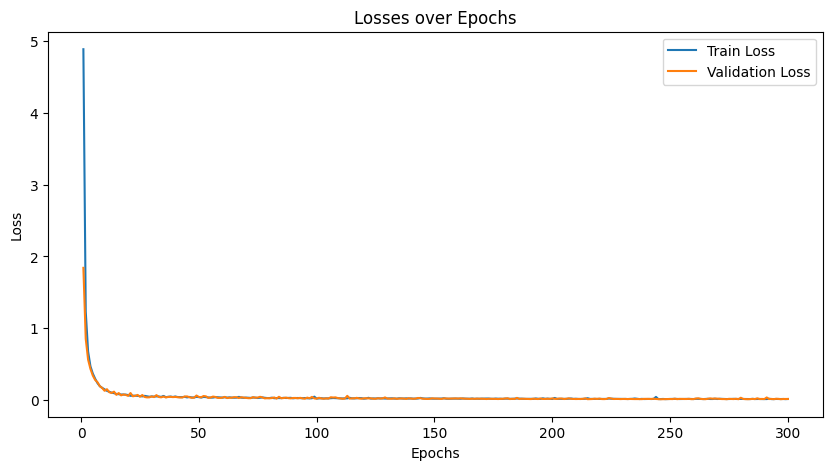

In [23]:
def plot_losses(train_loss, val_loss):
    epochs = np.arange(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_losses(history_xavier["train_loss"], history_xavier["val_loss"])

In [25]:
def calculate_model_performance(model_name):
    """Calculate and print model performance metrics"""
    model = LinearlyActuatedStrutsXavier() if model_name == "Xavier" else LinearlyActuatedStrutsHe()
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    
    # Rescale predictions back to [0, 73.8]
    pred_real = predictions * 73.8
    
    # Calculate metrics
    mse = nn.MSELoss()(pred_real, y_test * 73.8).item()
    mae = torch.mean(torch.abs(pred_real - y_test * 73.8)).item()
    
    print(f"Model: {model_name} | MSE: {mse:.4f} | MAE: {mae:.4f}")
    return pred_real, mse, mae


xavier_pred, xavier_mse, xavier_mae = calculate_model_performance("Xavier_Model_1e-3")

Model: Xavier_Model_1e-3 | MSE: 0.9149 | MAE: 0.5625


In [28]:
xavier_pred = torch.round(xavier_pred, decimals=1)
print(xavier_pred)

tensor([[73.6000, 73.8000, 73.8000,  0.8000,  0.1000, 69.2000],
        [ 0.1000,  0.2000, 57.6000,  0.2000, 47.8000,  0.0000],
        [49.5000, 29.0000,  0.4000, 17.1000, 24.1000, 22.9000],
        ...,
        [73.4000, 73.6000, 73.7000, 53.8000,  0.1000,  0.3000],
        [73.7000, 73.7000, 73.7000,  0.1000, 73.7000, 54.7000],
        [73.7000, 69.9000,  0.0000, 44.9000, 66.6000, 56.9000]])


In [27]:
y_test_scaled = y_test * 73.8
print(y_test_scaled)

tensor([[73.4300, 73.3600, 73.2900,  0.0000,  0.0000, 69.4700],
        [ 0.0000,  0.0000, 57.5600,  0.0000, 48.9800,  0.0000],
        [49.2700, 28.4200,  0.0000, 16.8800, 24.0200, 23.3700],
        ...,
        [73.8000, 73.7200, 73.8000, 54.3900,  0.0000,  0.0000],
        [73.8000, 73.8000, 73.8000,  0.0000, 73.8000, 54.6100],
        [73.5800, 71.1300,  0.0000, 44.6500, 67.7400, 56.7000]])


Now we will try with smaller learning rates

In [32]:
model_xavier_2 = LinearlyActuatedStrutsXavier()

# Train and evaluate
history_xavier_2 = train_model(
    model=model_xavier_2,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="Xavier_Model_5e-4",
    num_epochs=600,
    scale_factor=73.8,  # Your specific scaling factor
    lr= 5e-4,  # Learning rate for the second model
)

# Access results
print(f"Best validation loss with Xavier Initialization and Learning rate of 5e-4: {history_xavier_2['best_val_loss']:.4f} at epoch {history_xavier_2['epoch_best']}")

Epoch 1/600 | Train Loss: 6.8989 | Val Loss: 3.3473
Epoch 11/600 | Train Loss: 0.2090 | Val Loss: 0.2206
Epoch 21/600 | Train Loss: 0.0815 | Val Loss: 0.0795
Epoch 31/600 | Train Loss: 0.0516 | Val Loss: 0.0643
Epoch 41/600 | Train Loss: 0.0408 | Val Loss: 0.0371
Epoch 51/600 | Train Loss: 0.0361 | Val Loss: 0.0427
Epoch 61/600 | Train Loss: 0.0357 | Val Loss: 0.0419
Epoch 71/600 | Train Loss: 0.0313 | Val Loss: 0.0240
Epoch 81/600 | Train Loss: 0.0351 | Val Loss: 0.0267
Epoch 91/600 | Train Loss: 0.0255 | Val Loss: 0.0277
Epoch 101/600 | Train Loss: 0.0209 | Val Loss: 0.0224
Epoch 111/600 | Train Loss: 0.0234 | Val Loss: 0.0196
Epoch 121/600 | Train Loss: 0.0216 | Val Loss: 0.0226
Epoch 131/600 | Train Loss: 0.0182 | Val Loss: 0.0184
Epoch 141/600 | Train Loss: 0.0170 | Val Loss: 0.0173
Epoch 151/600 | Train Loss: 0.0191 | Val Loss: 0.0183
Epoch 161/600 | Train Loss: 0.0168 | Val Loss: 0.0187
Epoch 171/600 | Train Loss: 0.0159 | Val Loss: 0.0161
Epoch 181/600 | Train Loss: 0.0180 | Va

In [33]:
xavier_pred_2, xavier_mse_2, xavier_mae_2 = calculate_model_performance("Xavier_Model_5e-4")

Model: Xavier_Model_5e-4 | MSE: 0.6662 | MAE: 0.4856


Now we will try with He initialization

In [35]:
model_he = LinearlyActuatedStrutsHe()
# Train and evaluate
history_he = train_model(
    model=model_he,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_1e-3",
    num_epochs=500,
    scale_factor=73.8  # Your specific scaling factor
)

print(f"Best validation loss with He Initialization: {history_he['best_val_loss']:.4f} at epoch {history_he['epoch_best']}")

Epoch 1/500 | Train Loss: 4.4049 | Val Loss: 1.9047
Epoch 11/500 | Train Loss: 0.1512 | Val Loss: 0.1698
Epoch 21/500 | Train Loss: 0.0678 | Val Loss: 0.0881
Epoch 31/500 | Train Loss: 0.0424 | Val Loss: 0.0547
Epoch 41/500 | Train Loss: 0.0354 | Val Loss: 0.0294
Epoch 51/500 | Train Loss: 0.0330 | Val Loss: 0.0280
Epoch 61/500 | Train Loss: 0.0466 | Val Loss: 0.0204
Epoch 71/500 | Train Loss: 0.0207 | Val Loss: 0.0208
Epoch 81/500 | Train Loss: 0.0191 | Val Loss: 0.0207
Epoch 91/500 | Train Loss: 0.0209 | Val Loss: 0.0254
Epoch 101/500 | Train Loss: 0.0148 | Val Loss: 0.0146
Epoch 111/500 | Train Loss: 0.0177 | Val Loss: 0.0269
Epoch 121/500 | Train Loss: 0.0168 | Val Loss: 0.0148
Epoch 131/500 | Train Loss: 0.0147 | Val Loss: 0.0136
Epoch 141/500 | Train Loss: 0.0127 | Val Loss: 0.0120
Epoch 151/500 | Train Loss: 0.0122 | Val Loss: 0.0118
Epoch 161/500 | Train Loss: 0.0107 | Val Loss: 0.0102
Epoch 171/500 | Train Loss: 0.0186 | Val Loss: 0.0118
Epoch 181/500 | Train Loss: 0.0138 | Va

In [36]:
he_pred, he_mse, he_mae = calculate_model_performance("He_Model_1e-3")

he_pred = torch.round(he_pred, decimals=1)
print(he_pred)

Model: He_Model_1e-3 | MSE: 0.4668 | MAE: 0.4097
tensor([[73.5000, 73.8000, 73.8000,  0.4000,  0.1000, 69.8000],
        [ 0.0000,  0.1000, 58.5000,  0.0000, 48.9000,  0.0000],
        [48.8000, 29.9000,  0.2000, 17.4000, 25.1000, 24.3000],
        ...,
        [73.8000, 73.6000, 73.6000, 53.7000,  0.1000,  0.1000],
        [73.8000, 73.8000, 73.8000,  0.0000, 73.5000, 52.9000],
        [73.7000, 69.7000,  0.1000, 44.0000, 66.6000, 55.7000]])


In [37]:
he_model_2 = LinearlyActuatedStrutsHe()
# Train and evaluate
history_he_2 = train_model(
    model=he_model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_5e-4",
    num_epochs=600,
    scale_factor=73.8,  # Your specific scaling factor
    lr= 5e-4,  # Learning rate for the second model
)

print(f"Best validation loss with He Initialization and Learning rate of 5e-4: {history_he_2['best_val_loss']:.4f} at epoch {history_he_2['epoch_best']}")

Epoch 1/600 | Train Loss: 5.9647 | Val Loss: 3.1303
Epoch 11/600 | Train Loss: 0.2495 | Val Loss: 0.2627
Epoch 21/600 | Train Loss: 0.1110 | Val Loss: 0.1076
Epoch 31/600 | Train Loss: 0.0603 | Val Loss: 0.0642
Epoch 41/600 | Train Loss: 0.0463 | Val Loss: 0.0516
Epoch 51/600 | Train Loss: 0.0348 | Val Loss: 0.0299
Epoch 61/600 | Train Loss: 0.0361 | Val Loss: 0.0353
Epoch 71/600 | Train Loss: 0.0253 | Val Loss: 0.0266
Epoch 81/600 | Train Loss: 0.0260 | Val Loss: 0.0224
Epoch 91/600 | Train Loss: 0.0240 | Val Loss: 0.0316
Epoch 101/600 | Train Loss: 0.0191 | Val Loss: 0.0180
Epoch 111/600 | Train Loss: 0.0191 | Val Loss: 0.0294
Epoch 121/600 | Train Loss: 0.0211 | Val Loss: 0.0236
Epoch 131/600 | Train Loss: 0.0157 | Val Loss: 0.0130
Epoch 141/600 | Train Loss: 0.0150 | Val Loss: 0.0162
Epoch 151/600 | Train Loss: 0.0156 | Val Loss: 0.0130
Epoch 161/600 | Train Loss: 0.0144 | Val Loss: 0.0202
Epoch 171/600 | Train Loss: 0.0164 | Val Loss: 0.0152
Epoch 181/600 | Train Loss: 0.0155 | Va

In [38]:
he_pred_2, he_mse_2, he_mae_2 = calculate_model_performance("He_Model_5e-4")

he_pred_2 = torch.round(he_pred_2, decimals=1)
print(he_pred_2)


Model: He_Model_5e-4 | MSE: 0.5009 | MAE: 0.4107
tensor([[73.8000, 73.7000, 73.8000,  0.6000,  0.1000, 69.9000],
        [ 0.0000,  0.0000, 59.2000,  0.0000, 50.3000,  0.0000],
        [48.9000, 29.4000,  0.2000, 17.4000, 24.5000, 24.0000],
        ...,
        [73.6000, 73.6000, 73.6000, 54.4000,  0.1000,  0.0000],
        [73.7000, 73.5000, 73.8000,  0.0000, 73.4000, 52.2000],
        [73.7000, 70.2000,  0.1000, 45.2000, 67.5000, 57.1000]])
